<a href="https://colab.research.google.com/github/ankitstar01/ml_test/blob/master/Smart%20Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smart Composer

In [3]:
#importing os environment
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/Kaggle"
%cd Kaggle/

[Errno 2] No such file or directory: 'Kaggle/'
/content


In [8]:
shutil.copyfile("/content/drive/My Drive/Colab Notebooks/kaggle.json","/content/Kaggle/kaggle.json")
#downloading the kaggle dataset
!kaggle datasets download -d wcukierski/enron-email-dataset

#unzipping the zip files
!unzip \*.zip

100% 358M/358M [00:02<00:00, 148MB/s]

Archive:  enron-email-dataset.zip
  inflating: emails.csv              


In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import email
import re
import shutil

In [10]:
# shutil.move("/content/gdrive/My Drive/Kaggle/emails.csv","/content/emails.csv")
#reading the emails
if not 'emails_df' in locals():
    emails_df = pd.read_csv('/content/emails.csv')

In [11]:
#printing the matrix size and the top 5 rows of it
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [12]:
# Convert to message objects from the message strings
messages = list(map(email.message_from_string, emails_df['message']))

In [13]:
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    text = ''.join(parts)
    return text

emails = pd.DataFrame()

# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))
print(messages[2])
print(emails['content'][2])

Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>
Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
From: phillip.allen@enron.com
To: leah.arsdall@enron.com
Subject: Re: test
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Leah Van Arsdall
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

test successful.  way to go!!!
test successful.  way to go!!!


In [14]:
# import gc

# # Remove variables from memory
# del messages
# del emails_df
# gc.collect()

In [15]:
def normalize_text(text):
    text = text.lower()
  
  # creating a space between a word and the punctuation following it to separate words
  # and compact repetition of punctuation
  # eg: "he is a boy.." => "he is a boy ."
    text = re.sub(r'([.,!?]+)', r" \1 ", text)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,']+", " ", text)

  # Compact spaces
    text = re.sub(r'[" "]+', " ", text)

  # Remove forwarded messages
    text = text.split('forwarded by')[0]

    text = text.strip()

    return text

emails['content'] = list(map(normalize_text, emails['content']))

In [16]:
# Drop samples with empty content text after normalization
emails['content'].replace('', np.nan, inplace=True)
emails.dropna(subset=['content'], inplace=True)

In [17]:
#some sample emails
pd.set_option('max_colwidth', -1)
emails

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,content
0,here is our forecast
1,"traveling to have a business meeting takes the fun out of the trip . especially if you have to prepare a presentation . i would suggest holding the business plan meetings here then take a trip without any formal business meetings . i would even try and get some honest opinions on whether a trip is even desired or necessary . as far as the business meetings , i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not . too often the presenter speaks and the others are quiet just waiting for their turn . the meetings might be better if held in a round table discussion format . my suggestion for where to go is austin . play golf and rent a ski boat and jet ski's . flying somewhere takes too much time ."
2,test successful . way to go !!!
3,"randy , can you send me a schedule of the salary and level of everyone in the scheduling group . plus your thoughts on any changes that need to be made . patti s for example phillip"
4,let's shoot for tuesday at .
...,...
517396,"this is a trade with oil spec hedge ng john lavorato's book and john zufferli's book cand pwr pr cand pwr pr buys from oil spec hedge ng nymex gas cal , mmbtu day . cal cal , mmbtu day . cal cal , mmbtu day . cal cal , mmbtu day . please confirm receipt john z"
517397,"some of my position is with the alberta term book , i will send you only the positions that i have directly with ena ."
517398,"original message from doucet , dawn sent wednesday , november , am to zufferli , john subject confidential morning john , i'm still working on the mini prc for lavo . sean lalani has not yet been ranked and rumour has it that he reports to you now . can you confirm and send me a number . thanks !"
517399,analyst rank stephane brodeur chad clark ian cooke lon draper fabian taylor carlos torres ryan watt associate cooper richey


In the original paper, the dataset is built with emails where the context is provided by the email date, subject and previous message if the user is replying.Unfortunately, in the Enron dataset it's not possible to build the reply relationship between emails.Thus in order to generate the context of a sentence, we train the sequence-to-sequence model to predict the sentence completion from pairs of split sentences.

For instance, the sentence 'here is our forecast' is split in the following pairs within the dataset:

[
  ('<start> here is <end>', '<start> our forecast <end>'),
  ('<start> here is our <end>', '<start> forecast <end>')

In [18]:
# Skip long sentences, which increase maximum length a lot when padding
# and make the number of parameters to train explode
SENTENCE_MAX_WORDS = 20

def generate_dataset (emails):
    contents = emails['content']
    output = []
    vocabulary_sentences = []
    i=0
    for content in contents:
        # Skip emails longer than one sentence
        i=i+1
        if (len(content) > SENTENCE_MAX_WORDS * 5):
            continue

        sentences = content.split(' . ')
        for sentence in sentences:
            # Remove user names from start or end of sentence. This is just an heuristic
            # but it's more efficient than compiling the list of names and removing all of them
            sentence = re.sub("(^\w+\s,\s)|(\s,\s\w+$)", "", sentence)
            words = sentence.split(' ')

            if ((len(words) > SENTENCE_MAX_WORDS) or (len(words) < 2)):
                continue

            vocabulary_sentences.append('<start> ' + sentence + ' <end>')

            for i in range(1, len(words) - 1):
                input_data = '<start> ' + ' '.join(words[:i+1]) + ' <end>'
                output_data = '<start> ' + ' '.join(words[i+1:]) + ' <end>'
                data = (input_data, output_data)
                output.append(data)

    return output, vocabulary_sentences,i

pairs, vocabulary_sentences,i = generate_dataset(emails)
print(i)

37


In [19]:
#printing the length of the sentence pairs , the vocabulary , sentence pairs and corresponding sentence .
print(len(pairs))
print(len(vocabulary_sentences))
print(*pairs[:10], sep='\n')
print(*vocabulary_sentences[:10], sep='\n')

509918
104151
('<start> here is <end>', '<start> our forecast <end>')
('<start> here is our <end>', '<start> forecast <end>')
('<start> way to <end>', '<start> go !!! <end>')
('<start> way to go <end>', '<start> !!! <end>')
("<start> let's shoot <end>", '<start> for tuesday at . <end>')
("<start> let's shoot for <end>", '<start> tuesday at . <end>')
("<start> let's shoot for tuesday <end>", '<start> at . <end>')
("<start> let's shoot for tuesday at <end>", '<start> . <end>')
('<start> how about <end>', '<start> either next tuesday or thursday ? phillip <end>')
('<start> how about either <end>', '<start> next tuesday or thursday ? phillip <end>')
<start> here is our forecast <end>
<start> test successful <end>
<start> way to go !!! <end>
<start> let's shoot for tuesday at . <end>
<start> how about either next tuesday or thursday ? phillip <end>
<start> any morning between and <end>
<start> million is fine phillip <end>
<start> i think fletch has a good cpa <end>
<start> i am still doing

We need to transform the text corpora into sequences of integers (each integer being the index of a token in a dictionary) by using keras Tokenizer. We also limit to the 10k most frequent words, deleting uncommon words from sentences.

Normally we would use two tokenizers, one for the input strings and a different one for the output text, but in this case we are predicting the same vocabulary in both cases. All the words in the output texts are available also in the input texts because of how dataset pairs are generated.

In [20]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)

In [21]:
#tokenizer
vocab_max_size = 10000

def tokenize(text):
    tokenizer = keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_max_size)
    tokenizer.fit_on_texts(text)

    return tokenizer

input = [pair[0] for pair in pairs]
output = [pair[1] for pair in pairs]
tokenizer = tokenize(vocabulary_sentences)

encoder_input = tokenizer.texts_to_sequences(input)
decoder_input = tokenizer.texts_to_sequences(output)

decoder_target = [
  [decoder_input[seqN][tokenI + 1]
   for tokenI in range(len(decoder_input[seqN]) - 1)]
    for seqN in range(len(decoder_input))]

# Convert to np.array
encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

In [22]:
from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target, test_size=0.2)

In [23]:
#printing the 2d matrix dimensions 
print(encoder_input_train.shape, encoder_input_test.shape)
print(decoder_input_train.shape, decoder_input_test.shape)
print(decoder_target_train.shape, decoder_target_test.shape)

(407934,) (101984,)
(407934,) (101984,)
(407934,) (101984,)


In [24]:
def max_length(t):
    return max(len(i) for i in t)

max_length_in = max_length(encoder_input)
max_length_out = max_length(decoder_input)

encoder_input_train = keras.preprocessing.sequence.pad_sequences(encoder_input_train, maxlen=max_length_in, padding="post")
decoder_input_train = keras.preprocessing.sequence.pad_sequences(decoder_input_train, maxlen=max_length_out, padding="post")
decoder_target_train = keras.preprocessing.sequence.pad_sequences(decoder_target_train, maxlen=max_length_out, padding="post")

encoder_input_test = keras.preprocessing.sequence.pad_sequences(encoder_input_test, maxlen=max_length_in, padding="post")
decoder_input_test = keras.preprocessing.sequence.pad_sequences(decoder_input_test, maxlen=max_length_out, padding="post")
decoder_target_test = keras.preprocessing.sequence.pad_sequences(decoder_target_test, maxlen=max_length_out, padding="post")

In [25]:
#max input output sequence length
print(max_length_in, max_length_out)

21 20


In [26]:
# Shuffle the data in unison
p = np.random.permutation(len(encoder_input_train))
encoder_input_train = encoder_input_train[p]
decoder_input_train = decoder_input_train[p]
decoder_target_train = decoder_target_train[p]

q = np.random.permutation(len(encoder_input_test))
encoder_input_test = encoder_input_test[q]
decoder_input_test = decoder_input_test[q]
decoder_target_test = decoder_target_test[q]

In [27]:
import math

batch_size = 128
vocab_size = vocab_max_size if len(tokenizer.word_index) > vocab_max_size else len(tokenizer.word_index)
# Rule of thumb of embedding size: vocab_size ** 0.25
embedding_dim = math.ceil(vocab_size ** 0.25)
latent_dim = 192 # Latent dimensionality of the encoding space.

#printing the vocabulary size and embedding dimension 
print(vocab_size, embedding_dim)
len(tokenizer.word_index)

10000 10


15809

Here we define the RNN models. We start with the Encoder-Decoder model used in training which leverages the "teacher forcing technique". Therefore, it will receive as input encoder_input and decoder_input datasets.

Then the second model is represented by the inference Decoder which will receive as input the encoded states of the input sequence and the predicted token of the previous time step.

Both models use GRU units to preserve the context state, which have been shown to be more accurate than LSTM units and simpler to use since they have only one state.

In [28]:
# GRU Encoder
encoder_in_layer = keras.layers.Input(shape=(max_length_in,))
encoder_embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
encoder_bi_gru = keras.layers.Bidirectional(keras.layers.GRU(units=latent_dim, return_sequences=True, return_state=True))

# Discard the encoder output and use hidden states (h) and memory cells states (c)
# for forward (f) and backward (b) layer
encoder_out, fstate_h, bstate_h = encoder_bi_gru(encoder_embedding(encoder_in_layer))
state_h = keras.layers.Concatenate()([fstate_h, bstate_h])

# GRUDecoder
decoder_in_layer = keras.layers.Input(shape=(None,))
decoder_embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_gru = keras.layers.GRU(units=latent_dim * 2, return_sequences=True, return_state=True)
# Discard internal states in training, keep only the output sequence
decoder_gru_out, _ = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_h)
decoder_dense_1 = keras.layers.Dense(128, activation="relu")
decoder_dense = keras.layers.Dense(vocab_size, activation="softmax")
decoder_out_layer = decoder_dense(keras.layers.Dropout(rate=0.2)(decoder_dense_1(keras.layers.Dropout(rate=0.2)(decoder_gru_out))))

# Define the model that uses the Encoder and the Decoder
model = keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

def perplexity(y_true, y_pred):
    return keras.backend.exp(keras.backend.mean(keras.backend.sparse_categorical_crossentropy(y_true, y_pred)))

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[perplexity])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 10)       100000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 21, 384), (N 235008      embedding[0][0]                  
______________________________________________________________________________________________

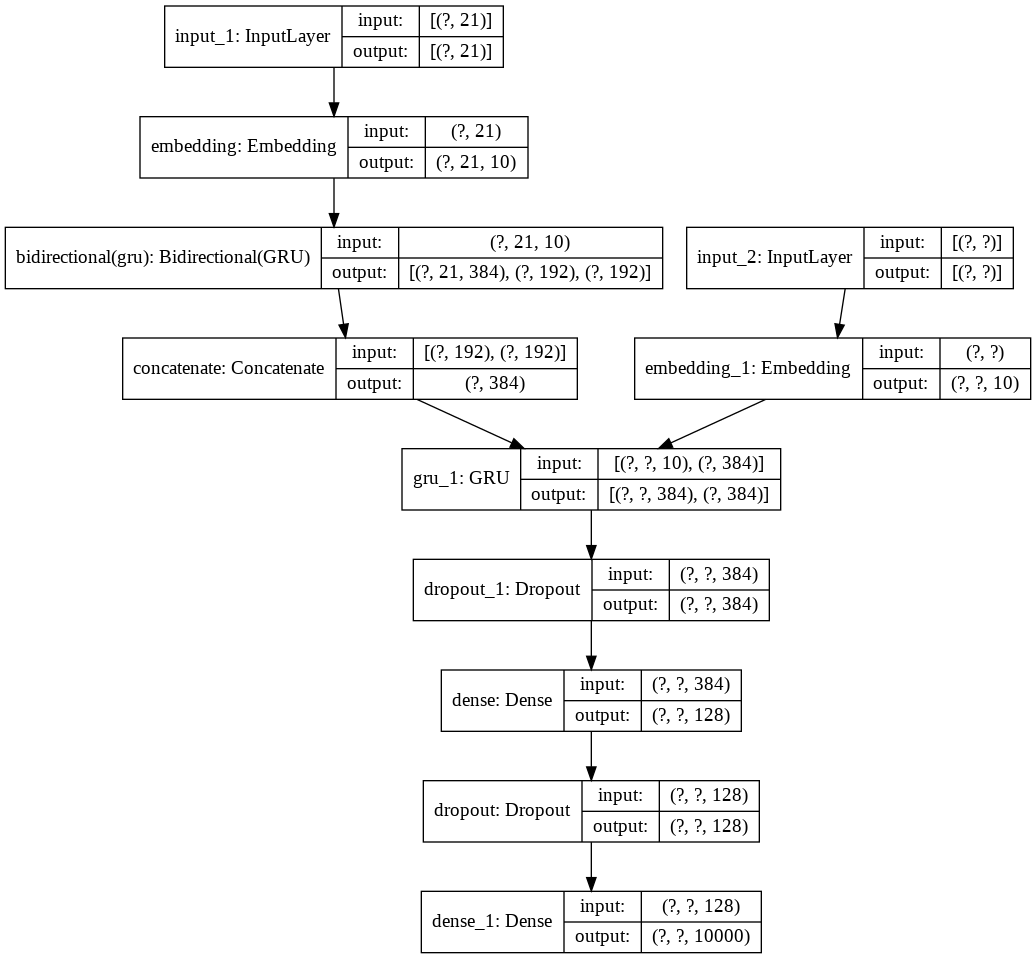

In [29]:
#encoder-decoder model structure
keras.utils.plot_model(model, "encoder-decoder.png", show_shapes=True)

Epoch 1/10
2550/2550 [==============================] - 304s 119ms/step - loss: 1.5912 - perplexity: 41.5718 - val_loss: 1.3088 - val_perplexity: 3.7151
Epoch 2/10
2550/2550 [==============================] - 304s 119ms/step - loss: 1.2120 - perplexity: 3.3778 - val_loss: 1.0641 - val_perplexity: 2.9058
Epoch 3/10
2550/2550 [==============================] - 305s 120ms/step - loss: 1.0325 - perplexity: 2.8175 - val_loss: 0.9103 - val_perplexity: 2.4900
Epoch 4/10
2550/2550 [==============================] - 304s 119ms/step - loss: 0.9202 - perplexity: 2.5157 - val_loss: 0.8109 - val_perplexity: 2.2535
Epoch 5/10
2550/2550 [==============================] - 304s 119ms/step - loss: 0.8461 - perplexity: 2.3349 - val_loss: 0.7474 - val_perplexity: 2.1145
Epoch 6/10
2550/2550 [==============================] - 304s 119ms/step - loss: 0.7954 - perplexity: 2.2189 - val_loss: 0.7026 - val_perplexity: 2.0215
Epoch 7/10
2550/2550 [==============================] - 303s 119ms/step - loss: 0.7590 

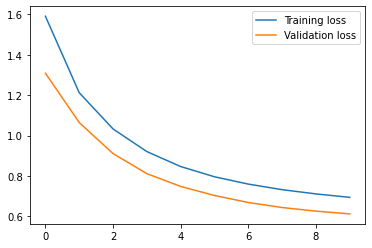

In [30]:
#training the model and printing the training and validation losses
epochs = 10
history = model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.2)

def plot_history(history):
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.legend()

plot_history(history)

In [31]:
#printing the best loss and perplexity achievable
scores = model.evaluate([encoder_input_test[:1000], decoder_input_test[:1000]], decoder_target_test[:1000])
print("%s: %.2f" % (model.metrics_names[1], scores[1]))

32/32 [==============================] - 1s 17ms/step - loss: 0.5982 - perplexity: 1.8203
perplexity: 1.82


In [32]:
# Inference Decoder
encoder_model = keras.models.Model(encoder_in_layer, state_h)

state_input_h = keras.layers.Input(shape=(latent_dim * 2,))
inf_decoder_out, decoder_h = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_input_h)
inf_decoder_out = decoder_dense(decoder_dense_1(inf_decoder_out))
inf_model = keras.models.Model(inputs=[decoder_in_layer, state_input_h], 
                  outputs=[inf_decoder_out, decoder_h])

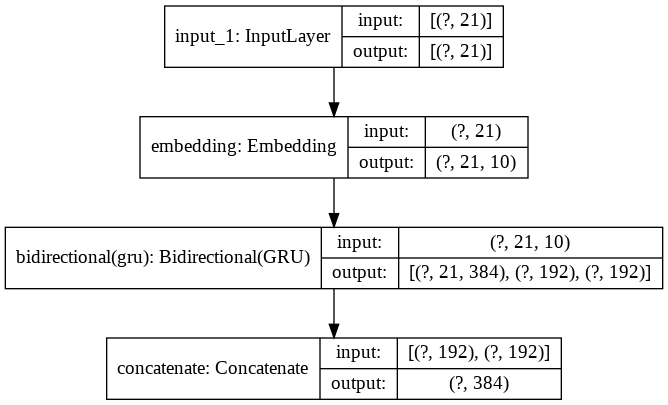

In [33]:
#the encoder model structure
keras.utils.plot_model(encoder_model, "encoder-model.png", show_shapes=True)

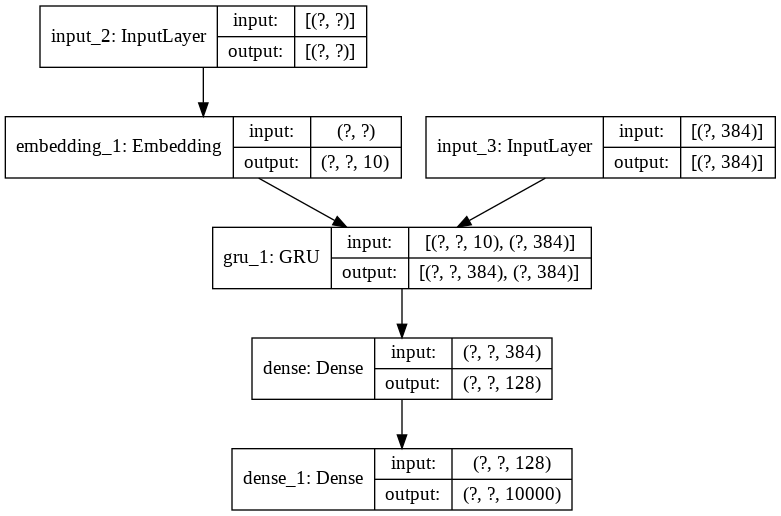

In [34]:
#inference model structure
keras.utils.plot_model(inf_model, "inference-model.png", show_shapes=True)

In [36]:
def tokenize_text(text):
    text = '<start> ' + text.lower() + ' <end>'
    text_tensor = tokenizer.texts_to_sequences([text])
    text_tensor = keras.preprocessing.sequence.pad_sequences(text_tensor, maxlen=max_length_in, padding="post")
    return text_tensor

# Reversed map from a tokenizer index to a word
index_to_word = dict(map(reversed, tokenizer.word_index.items()))

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def decode_sequence(input_tensor):
    # Encode the input as state vectors.
    state = encoder_model.predict(input_tensor)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (max_length_out - 1):
        output_tokens, h = inf_model.predict([target_seq, state])
        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
            break;

        curr_word = index_to_word[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1

    return decoded_sentence
  #converting tokens to sequence
def tokens_to_seq(tokens):
    words = list(map(lambda token: index_to_word[token] if token != 0 else '', tokens))
    return ' '.join(words)
tokenize_text('have a')

array([[ 1, 22, 14,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]], dtype=int32)

In [37]:
#testing of the inference models with some inputs inside the text array (note-the input must be present inside the splitted pairs of sentence)
texts = [
    'are you',
    'have a',
    'please review',
    'please call me',
    'thanks for',
    'let me',
    'Let me know',
    'Let me know if you',
    'this sounds',
    'is this call going to',
    'can you get',
    'is it okay',
    'it should',
    'call if there\'s',
    'gave her a',
    'i will let',
    'i will be',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'i am fine with the changes',
    'please be sure this'
]
#inference outputs
output = list(map(lambda text: (text, decode_sequence(tokenize_text(text))), texts))

output_df = pd.DataFrame(output, columns=["input", "output"])
output_df.head(len(output))

,input,output
0,are you,going to ? <end>
1,have a,good weekend <end>
2,please review,the attached outage report <end>
3,please call me,to discuss <end>
4,thanks for,the info <end>
5,let me,know if you have any questions <end>
6,Let me know,if you have any questions <end>
7,Let me know if you,have any questions <end>
8,this sounds,like to be the goof today <end>
9,is this call going to,get a chance to you ? <end>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
